# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [ ]:
#!pip install -r requirements.txt


Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [23]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import math
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [24]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [25]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
        self.memory += other.memory
        return self

    def __add__(self, other):
        self.memory = self.memory + other.memory
        return self

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [26]:
from copy import deepcopy

def rollout_function(multitree, num_episodes=5, episode_duration=300, ignore_done=False, render=False, seed=None):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")

    episode_rewards = np.zeros((num_episodes, episode_duration))
    if render:
        frames = []

    for i in range(num_episodes):
        # get initial state of the environment
        # if a seed is given, set the seed of each episode
        if seed:
            observation = env.reset(seed=seed+i)
        else:
            observation = env.reset()
        observation = observation[0]
        rewards = np.zeros(episode_duration)
        for j in range(episode_duration):
            if render:
                frames.append(env.render())
            input_sample = observation.reshape((1, -1))
            action = np.argmax(multitree.get_output(input_sample))
            observation, reward, terminated, truncated, info = env.step(action.item())
            rewards[j] = reward
            if (terminated or truncated) and not ignore_done:
                break
        episode_rewards[i, :] = rewards

    if render:
        return episode_rewards, frames
    return episode_rewards, []

def calculate_returns(episode_rewards, gamma=0.99):
    num_steps = episode_rewards.shape[1]
    g = np.power(gamma, np.arange(num_steps))
    returns = np.sum(episode_rewards * g, axis=1)
    return returns

def fitness_baseline(episode_rewards, pop):
    return np.mean(np.sum(episode_rewards, axis=1))

def fitness_discounted_return(episode_rewards, pop):
    return np.mean(calculate_returns(episode_rewards))

def fitness_discounted_return_len_sqrt_std(episode_rewards, pop):
    return np.mean(calculate_returns(episode_rewards)) - len(pop) - np.std(np.sum(episode_rewards, axis=1))**0.5

def fitness_function_mean_len_sqrt_std(episode_rewards, pop):
    return np.mean(np.sum(episode_rewards, axis=1)) - len(pop) - np.std(np.sum(episode_rewards, axis=1))**0.5

def fitness_function_mean_len_std(episode_rewards, pop):
    return np.mean(np.sum(episode_rewards, axis=1)) - len(pop) - np.std(np.sum(episode_rewards, axis=1))

def fitness_function_mean_len_quarter_std(episode_rewards, pop):
    return np.mean(np.sum(episode_rewards, axis=1)) - len(pop) - 0.25*np.std(np.sum(episode_rewards, axis=1))


## Fitness function: symmetric approach

For the side-correction thruster symmetry we will be using the same tree for the side thrusters. The only difference between the right and left thruster trees will be that some feature nodes that correspond with symmetry are inverted as follows:

```
           *
f(x) ->   / \
        -1   f(2) 
```

In [27]:
from copy import deepcopy
from genepro.thruster_symmetry import traverse_and_invert_iter


def rollout_function_symmetry(multitree, num_episodes=5, episode_duration=300, ignore_done=False, render=False, seed=None):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    
    # here, we generate the right thruster tree using the left thruster tree
    left_thruster_tree = deepcopy(multitree.children[1])
    right_thruster_tree = left_thruster_tree
    right_thruster_tree = traverse_and_invert_iter(left_thruster_tree, feature_ids = [0,2,4,5,6,7])

    episode_rewards = []
    if render:
        frames = []

    for _ in range(num_episodes):
        # get initial state of the environment
        # if a seed is given, set the seed of each episode
        if seed:
            observation = env.reset(seed=seed+i)
        else:
            observation = env.reset()
        observation = env.reset()
        observation = observation[0]
        rewards = []
        for _ in range(episode_duration):
            if render:
                frames.append(env.render())
            input_sample = observation.reshape((1, -1))
            
            outputs = multitree.get_output(input_sample)
            outputs = np.append(outputs, right_thruster_tree.get_output(input_sample))
            
            action = np.argmax(outputs)
            observation, reward, terminated, truncated, info = env.step(action.item())
            rewards.append(reward)
            if (terminated or truncated) and not ignore_done:
                break
        episode_rewards.append(np.sum(rewards))

    # Get the average reward over all episodes
    episode_rewards = np.array(episode_rewards)
    if render:
        return episode_rewards, frames
    return episode_rewards, []

In [28]:
### USED TO STORE THE EXPERIMENT DICTIONARY
import inspect
import itertools
import pickle

def serialize_functions_in_dict(dictionary):
    for key, value in dictionary.items():
        if inspect.isfunction(value) or inspect.ismethod(value):
            dictionary[key] = value.__name__
        elif isinstance(value, list):
            for i, item in enumerate(value):
                if isinstance(item, dict):
                    value[i] = serialize_functions_in_dict(item)
                elif inspect.isfunction(item) or inspect.ismethod(item):
                    value[i] = item.__name__
                elif isinstance(item, Node):
                    value[i] = item.symb
        elif isinstance(value, dict):
            dictionary[key] = serialize_functions_in_dict(value)
    return dictionary

### USED TO CREATE THE EXPERIMENT DICTIONARY
def grid_search_params(params_dict):
    """
    Given a dictionary of hyperparameters, if a value is a list, loop over all values
    and create a grid search.
    """
    param_keys = params_dict.keys()
    param_values = params_dict.values()
    param_combinations = list(itertools.product(*[v if isinstance(v, list) else [v] for v in param_values]))
    for combination in param_combinations:
        yield dict(zip(param_keys, combination))

In [29]:
# Save the gen as a pickle file in the gens folder
def save_and_evaluate_evo_generations(evo, rollout_function, experiment_name, num_episodes=10):
    generation_evo_fitnesses = []
    generation_test_fitnesses = []
    for i, gen in enumerate(evo.best_of_gens):
        if i == 0:
            continue

        episode_rewards, _ = rollout_function(gen, num_episodes=num_episodes)
        evo_fitness_mean, evo_fitness_std = round(np.mean(gen.fitnesses), 3), round(np.std(gen.fitnesses), 3)
        test_fitness_mean, test_fitness_std  = round(np.mean(np.sum(episode_rewards, axis=1)), 3), round(np.std(np.sum(episode_rewards, axis=1)), 3)
        print(f"Best of Generation {i}: evo fitness:{evo_fitness_mean}+/-{evo_fitness_std} \t test_fitness:{test_fitness_mean}+/-{test_fitness_std}")
        
        generation_evo_fitnesses.append(gen.fitnesses)
        generation_test_fitnesses.append(np.sum(episode_rewards, axis=1))
        # create the gens folder if it doesn't exist
        # os.makedirs(f"./experiments/{experiment_name}/gen/", exist_ok=True) 
        # with open(f"./experiments/{experiment_name}/gen/gen_{i}_{evo_fitness_mean}_{test_fitness_mean}.pickle", "wb") as f:
        #     pickle.dump(gen, f)

    np.save(f"./experiments/{experiment_name}/generation_evo_fitnesses.npy", generation_evo_fitnesses)
    np.save(f"./experiments/{experiment_name}/generation_test_fitnesses.npy", generation_test_fitnesses)   
    return generation_evo_fitnesses, generation_test_fitnesses

def plot_evo_test_fitnesses(evo_fitnesses, test_fitnesses, experiment_name):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Fitnesses: {experiment_name}")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Fitness")
    ax.plot(np.arange(len(evo_fitnesses)), [np.mean(gen) for gen in evo_fitnesses], label="evo_fitness", color='tab:blue')
    ax.fill_between(np.arange(len(evo_fitnesses)), [np.mean(gen) - np.std(gen) for gen in evo_fitnesses], [np.mean(gen) + np.std(gen) for gen in evo_fitnesses], alpha=0.2, color='tab:blue')
    ax.plot(np.arange(len(test_fitnesses)), [np.mean(gen) for gen in test_fitnesses], label="test_fitness", color='tab:orange')
    ax.fill_between(np.arange(len(test_fitnesses)), [np.mean(gen) - np.std(gen) for gen in test_fitnesses], [np.mean(gen) + np.std(gen) for gen in test_fitnesses], alpha=0.2, color='tab:orange')
    ax.legend()
    plt.savefig(f"./experiments/{experiment_name}/{experiment_name}.png")
    plt.close()

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

#### BASELINE

In [30]:
from copy import deepcopy
import json

## HERE ARE THE EXTRA SELECTION FUNCTIONS
from genepro.selection import elitism_selection, tournament_selection, roulette_selection, boltzmann_selection, rank_selection
from genepro.variation import coeff_mutation, subtree_crossover, subtree_mutation

experiment_name = "baseline"
num_features = env.observation_space.shape[0]
evo_settings = {
    "rollout_function": rollout_function,
    "fitness_function": fitness_baseline,
    "internal_nodes": [[Plus(), Times(), Div(), Sin(), Sqrt(), Square()]],
    "leaf_nodes": [[Feature(i) for i in range(num_features)] + [Constant()]],
    "n_trees": 4,
    "pop_size": 32,
    "max_gens": 500,
    "init_max_depth": 4,
    "max_tree_size": 32,
    "crossovers": [[{"fun": subtree_crossover, "rate": 0.5}]],
    "mutations": [[{"fun": subtree_mutation, "rate": 0.5}]],
    "coeff_opts": [[{"fun": coeff_mutation, "rate": 0.5}]],
    "selection": {"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
    "n_jobs": 8,
    "verbose": True
}

### FITNESS EXAMPLE


In [ ]:

experiment_name = "fitness"
num_features = env.observation_space.shape[0]
evo_settings = {
    "rollout_function": rollout_function,
    "fitness_function": fitness_discounted_return,
    "internal_nodes": [[Plus(), Times(), Div(), Sin(), Sqrt(), Square()]],
    "leaf_nodes": [[Feature(i) for i in range(num_features)] + [Constant()]],
    "n_trees": 4,
    "pop_size": 32,
    "max_gens": 500,
    "init_max_depth": 4,
    "max_tree_size": 32,
    "crossovers": [[{"fun": subtree_crossover, "rate": 0.5}]],
    "mutations": [[{"fun": subtree_mutation, "rate": 0.5}]],
    "coeff_opts": [[{"fun": coeff_mutation, "rate": 0.5}]],
    "selection": {"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
    "n_jobs": 8,
    "verbose": True
}

### SYMMETRY SETTINGS

In [ ]:

experiment_name = "symmetry"
num_features = env.observation_space.shape[0]
evo_settings = {
    "rollout_function": rollout_function_symmetry,
    "fitness_function": fitness_baseline,
    "internal_nodes": [[Plus(), Times(), Div(), Sin(), Sqrt(), Square()]],
    "leaf_nodes": [[Feature(i) for i in range(num_features)] + [Constant()]],
    "n_trees": 3,
    "pop_size": 32,
    "max_gens": 500,
    "init_max_depth": 4,
    "max_tree_size": 32,
    "crossovers": [[{"fun": subtree_crossover, "rate": 0.5}]],
    "mutations": [[{"fun": subtree_mutation, "rate": 0.5}]],
    "coeff_opts": [[{"fun": coeff_mutation, "rate": 0.5}]],
    "selection": {"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
    "n_jobs": 8,
    "verbose": True
}

### SELECTION SETTINGS


In [ ]:
experiment_name = "selection"
num_features = env.observation_space.shape[0]
evo_settings = {
    "rollout_function": rollout_function,
    "fitness_function": fitness_baseline,
    "internal_nodes": [[Plus(), Times(), Div(), Sin(), Sqrt(), Square()]],
    "leaf_nodes": [[Feature(i) for i in range(num_features)] + [Constant()]],
    "n_trees": 3,
    "pop_size": 32,
    "max_gens": 500,
    "init_max_depth": 4,
    "max_tree_size": 32,
    "crossovers": [[{"fun": subtree_crossover, "rate": 0.5}]],
    "mutations": [[{"fun": subtree_mutation, "rate": 0.5}]],
    "coeff_opts": [[{"fun": coeff_mutation, "rate": 0.5}]],

    # Uncomment selection method to use
    
    # "selection": {"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
    "selection": {"fun": elitism_selection}, 
    # "selection": {"fun": roulette_selection},
    # "selection": {"fun": boltzmann_selection, "kwargs": {"temperature": 0.5}},
    # "selection": {"fun": boltzmann_selection, "kwargs": {"temperature": 10.0}},
    # "selection": {{"fun": rank_selection},
                  
    "n_jobs": 8,
    "verbose": True
}

In [31]:
from copy import deepcopy
import json
from genepro.selection import elitism_selection, tournament_selection, roulette_selection, boltzmann_selection, rank_selection
from genepro.variation import coeff_mutation, subtree_crossover, subtree_mutation



def hpo_evolve(evo_settings, experiment_name):
    hpo_settings = list(grid_search_params(evo_settings))
    for settings in hpo_settings:
        serialized_dict = serialize_functions_in_dict(deepcopy(settings))
        print(serialized_dict)
        
    for i, settings in enumerate(hpo_settings):
        specific_experiment_name = experiment_name + f"_pops{settings['pop_size']}_gens{settings['max_gens']}_mts{settings['max_tree_size']}_cor{settings['crossovers'][0]['rate']}_mutr{settings['mutations'][0]['rate']}_coeffr{settings['coeff_opts'][0]['rate']}"
        os.makedirs(f"./experiments/{specific_experiment_name}", exist_ok=True)
        with open(f"./experiments/{specific_experiment_name}/evo_settings.json", "w") as f:
            serialized_dict = serialize_functions_in_dict(deepcopy(settings))
            json.dump(serialized_dict, f)

        evo_baseline = Evolution(**settings)
        evo_baseline.evolve()

        with open(f"./experiments/{specific_experiment_name}/evolution_class.pickle", "wb") as f:
            pickle.dump(evo_baseline, f)
        
        generation_evo_fitnesses, generation_test_fitnesses = save_and_evaluate_evo_generations(evo_baseline, evo_settings['rollout_function'], specific_experiment_name, num_episodes=5)
        plot_evo_test_fitnesses(generation_evo_fitnesses, generation_test_fitnesses, specific_experiment_name)


# Uncomment to run experiments

# for i in range(n_experiments:=4):
#     hpo_evolve(evo_settings, experiment_name=f'{experiment_name}_exp{i}')

### The following code will reevaluate experiments by loading the evolution_class.pickle and retesting each best-gen.

In [32]:
import pickle
import json

def get_evolution_pickle_files(folder_prefix, root_dir='./experiments'):
    evo_files = []
    evo_setting_files = []
    for root, dirs, files in os.walk(root_dir):
        if os.path.basename(root).startswith(folder_prefix):
            for file in files:
                file_path = os.path.join(root, file)
                if file.startswith('evolution_class.pickle'):
                    evo_files.append(file_path)
                if file.startswith('evo_settings.json'):
                    evo_setting_files.append(file_path)
                    
    return evo_files, evo_setting_files

def re_evaluate_experiment(folder_prefix, rollout_function, root_dir='./experiments'):
    evo_files, evo_setting_files = get_evolution_pickle_files(folder_prefix, root_dir)
    for i, (evo_file, evo_setting_file) in enumerate(zip(evo_files, evo_setting_files)):
        with open(evo_file, 'rb') as file:
            evo = pickle.load(file)
        print('Loaded:', evo_file)
        
        with open(evo_setting_file, 'rb') as file:
            settings = json.load(file)
        specific_experiment_name = folder_prefix + f"reev_exp{i}_pops{settings['pop_size']}_gens{settings['max_gens']}_mts{settings['max_tree_size']}_cor{settings['crossovers'][0]['rate']}_mutr{settings['mutations'][0]['rate']}_coeffr{settings['coeff_opts'][0]['rate']}"
        print(specific_experiment_name)

        generation_evo_fitnesses, generation_test_fitnesses = save_and_evaluate_evo_generations(evo, rollout_function, specific_experiment_name, num_episodes=5)
        plot_evo_test_fitnesses(generation_evo_fitnesses, generation_test_fitnesses, specific_experiment_name)

# Uncomment to re-evaluate experiments
# re_evaluate_experiment("fitness_decay", rollout_function)

## Evaluating the effect of hyperparameter optimization

We will look at what benefits hyperparameter optimization can have on our code.  We will be considering individuals from the baseline evolution as well as the symmetrical evolution experiments.

### Step 1: get best individuals
Each experiment has 500 individuals that were the best of their generation.  From each experiment, we will re-evaluate the performance of these individuals in a gym environment with a set random seed, and select the $n$ best individuals from each experiment.

### Step 2: perform hyperparameter optimization
On this list of individuals, consisting of $m \times n$ individuals, where m is the number of experiment runs, we will perform coefficitent optimization.  We will be using a simple hill-climbing method that probabilistically selects a subset of the constants and mutates them with a step size (up or down).  

### Step 3: get test results
Finally, we will get test results on a third test run, where we also set the random seed.  The resulting fitnesses will be plotted in a boxplot, where we can see the differences between runs.

In [33]:
def get_test_fitness(multitree, rollout_function, fitness_function=fitness_baseline, seed=None, verbose=False):
    """
    runs an individual multitree through a rollout and fitness function on an environment with a set seed
    """
    test_fitness = fitness_function(*rollout_function(multitree, seed=seed))
    if verbose:
        print(f"test score: {test_fitness}")
    return test_fitness


def best_test_individuals(multitrees, rollout_function, fitness_function = fitness_baseline, n = 15, seed = 42):
    """
    This function takes a list of individuals (such as the best_of_gens individuals from an experiment) and
    re-runs them in an environment with a seed set by the `seed` argument.  It selects the `n` individuals with
    the highest test score and returns them
    """
    return sorted(multitrees, key=lambda m: get_test_fitness(m, rollout_function, fitness_function, seed), reverse=True)[:n]


In [34]:
def get_constants(multitree):
    constants=[]
    for child in multitree.children:
        constants.extend([node for node in child.get_subtree() if isinstance(node, Constant)])
    return constants

def hill_climb_constants(multitree, rollout_function, step_size_mean=0.2, step_size_std=0.1, p=1, n_iter=20, patience=5):
    """Hill-climbing algorithm for optimizing a reward function.

    Args:
        multitree: A MultiTree object representing the search space.
        rollout_function: A function that takes a MultiTree object and returns a reward value.
        step_size_mean: The mean value for the step size.
        step_size_std: The standard deviation value for the step size.
        p: The probability of selecting a constant to mutate.
        n_iter: The maximum number of iterations to perform.
        patience: The number of iterations without improvement before stopping.

    Returns:
        A MultiTree object representing the best tree found.
    """
    best_tree = copy.deepcopy(multitree)
    best_reward = get_test_fitness(best_tree, rollout_function, seed=42)
    n_constants = len(best_tree.get_subtrees_consts())
    if n_constants==0:
        return best_tree
    n_mutate = int(math.ceil(p * n_constants))

    no_improvement_count = 0  # Counter for iterations without improvement

    while no_improvement_count < patience:
        new_trees = []
        for _ in range(n_mutate):
            new_tree = copy.deepcopy(best_tree)
            new_tree_constants = np.random.choice(get_constants(new_tree), n_mutate, replace=False)
            for c in new_tree_constants:
                step_size = np.random.normal(loc=step_size_mean, scale=step_size_std)
                new_value = c.get_value() + np.random.choice([-1, 1]) * step_size
                c.set_value(new_value)
            new_trees.append(new_tree)

        rewards = [get_test_fitness(tree, rollout_function, seed=42) for tree in new_trees]
        if rewards:    
            best_idx = np.argmax(rewards)
        
            if rewards[best_idx] > best_reward:
                print("New best reward: {}".format(rewards[best_idx]))
                best_tree = new_trees[best_idx]
                best_reward = rewards[best_idx]
                no_improvement_count = 0  # Reset the counter
            else:
                no_improvement_count += 1

    return best_tree

In [14]:
# first we load the pickle files of the experiments we want
baseline_folder_prefix = "baseline_exp"

baseline_pickle_files, _ = get_evolution_pickle_files(baseline_folder_prefix)

In [15]:
# then, we select the best indifiduals from each experiment run
n_selected = 15
random_seed = 10

fitness_function = fitness_baseline

baseline_individuals = []

# Uncomment to re-evaluate experiments

# for i, file in enumerate(baseline_pickle_files):
#     with open(file, "rb") as f:
#         evo = pickle.load(f)
#     print(f"processing pickle file {i}")
#     print(evo)
#     best_of_gens = evo.best_of_gens
#     best_tested = best_test_individuals(best_of_gens, rollout_function, n=n_selected, seed=random_seed)
#     baseline_individuals.append(best_tested)

In [35]:
# Uncomment below when re-evaulating experiments to save new results

# # we save the individuals to pickle files
# with open('./coefficient_optimization/baseline_individuals.pickle', 'wb') as f:
#     pickle.dump(baseline_individuals, f)

# Comment below if the above was uncommented, otherwise keep it uncommented to load the results from pickle files

# load from pickle files
with open('./coefficient_optimization/baseline_individuals.pickle', 'rb') as f:
    baseline_individuals = pickle.load(f)


In [ ]:
optimized_trees = []
import itertools


# Uncomment below to run optimization

# for i, gen in enumerate(list(itertools.chain(*baseline_individuals))):
#     print(f"indivdual {i}")
#     # print(f"number of constants {len(ind.get_subtrees_consts())}")
#     better = hill_climb_constants(gen, rollout_function)
#     optimized_trees.append(better)
    

In [36]:
# # Uncomment below to save the optimized trees
# # save the optimized trees
# with open('./coefficient_optimization/optimized_baseline.pickle', 'wb') as f:
#     pickle.dump(optimized_trees, f)

# Comment below if the above was uncommented, otherwise keep it uncommented to load the results from pickle files
# load the optimized trees
with open('./coefficient_optimization/optimized_baseline.pickle', 'rb') as f:
    optimized_trees = pickle.load(f)

baseline_results_test =[]
optimized_results_test =[]

seed = 63

for i, gen in enumerate(list(itertools.chain(*baseline_individuals))):
    baseline_results_test.append(get_test_fitness(gen, rollout_function, seed=seed))
    # if i==43:
    #     print(f"Baseline gen {i}")
    #     print(gen.get_subtrees_consts())

    

for i, gen in enumerate(optimized_trees):
    optimized_results_test.append(get_test_fitness(gen, rollout_function, seed=seed))
    # if i==43:
    #     print(f"Optimized gen {i}")
    #     print(gen.get_subtrees_consts())



112.54070309868334
-13.774660453145179


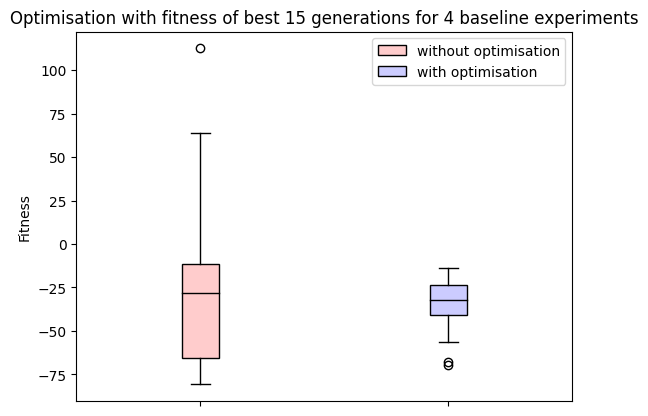

In [37]:
# make a boxplot of the original trees and the optimized trees

fig, ax = plt.subplots()

print(np.max(baseline_results_test))
print(np.max(optimized_results_test))

boxplot = ax.boxplot([baseline_results_test, optimized_results_test], patch_artist=True)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(boxplot[element], color="black")

evo_box = boxplot["boxes"][0]
evo_box.set_facecolor((1, 0, 0, 0.2))
evo_box.set_edgecolor("black")

test_box = boxplot["boxes"][1]
test_box.set_facecolor((0, 0, 1, 0.2))
test_box.set_edgecolor("black")  


ax.legend([evo_box, test_box], ["without optimisation", "with optimisation"])
ax.set_title(f"Optimisation with fitness of best {15} generations for {4} baseline experiments")
ax.set_ylabel("Fitness")

plt.xticks([1, 2], ["", ""], rotation=45)

plt.savefig(f"{'coefficient_optimization'}/baseline_optimisation_boxplot.png")


## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [38]:
# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path="./", filename="evolved_lander.gif"):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer="imagemagick", fps=60)

In [22]:
# frames from the baseline experiment
best_baseline_ind = np.argmax(baseline_results_test)
best_baseline = list(itertools.chain(*baseline_individuals))[best_baseline_ind]

baseline_rollout, baseline_frames = rollout_function(multitree, num_episodes=5, episode_duration=300, ignore_done=False, render=True, seed=63) 



# # frames from the optimized baseline experiment


# # frames from the symmetry experiment
# symmetry_folder_prefix = "fitness_symmetry"

# # frames from the 

# frames = []
# avg_fitness, frames = get_test_score(evo.best_of_gens[-1], num_episodes=5, episode_duration=300, seed=5, render=True)
# print("Average fitness of the render is: ", avg_fitness)
# env.close()
# save_frames_as_gif(frames)

NameError: name 'multitree' is not defined

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [ ]:
# batch_size = 128
# GAMMA = 0.99

# constants = best.get_subtrees_consts()

# if len(constants) > 0:
#     optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

# for _ in range(500):
#     if len(constants) > 0 and len(evo.memory) > batch_size:
#         target_tree = copy.deepcopy(best)

#         transitions = evo.memory.sample(batch_size)
#         batch = Transition(*zip(*transitions))

#         non_final_mask = torch.tensor(
#             tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool
#         )

#         non_final_next_states = torch.cat(
#             [s for s in batch.next_state if s is not None]
#         )
#         state_batch = torch.cat(batch.state)
#         action_batch = torch.cat(batch.action)
#         reward_batch = torch.cat(batch.reward)

#         state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
#         next_state_values = torch.zeros(batch_size, dtype=torch.float)
#         with torch.no_grad():
#             next_state_values[non_final_mask] = (
#                 target_tree.get_output_pt(non_final_next_states).max(1)[0].float()
#             )

#         expected_state_action_values = (next_state_values * GAMMA) + reward_batch

#         criterion = nn.SmoothL1Loss()
#         loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

#         # Optimize the model
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_value_(constants, 100)
#         optimizer.step()

# print(best.get_readable_repr())
# print(get_test_score(best))

In [ ]:
# frames = []
# fitness_function_pt(
#     best, num_episodes=1, episode_duration=500, render=True, ignore_done=False
# )
# env.close()
# save_frames_as_gif(frames, filename="evolved_lander_RL.gif")

<img src="evolved_lander_RL.gif" width="750">